In [1]:
import numpy as np
from scipy.linalg import schur
import tensorflow as tf
from backend.networks import Model
import backend as be
from backend.simulation_tools import Simulator
from tasks import n_fixed_points as fp
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
    
    #model params
    #n_in = n_out = 5 #number of fixed points
    #n_rec = 10 
    #n_steps = 80 
    tau = 100.0 #As double
    dt = 20.0  #As double
    dale_ratio = 0
    rec_noise = 0.01
    stim_noise = 0.1
    batch_size = 128 #256
    #var_delay_length = 50
    
    n_back = 0
    
    #train params
    learning_rate = .0001 
    training_iters = 2000000
    display_step = 200
    
    weights_path = '../weights/n_fps50.npz'
#     weights_path = '../weights/n_fps4by8_2.npz'
#     weights_path = '../weights/n_fps6by8_1.npz'
    
    weights = np.load(weights_path)
    
    n_in = n_out = weights['W_in'].shape[1]
    n_rec = weights['W_rec'].shape[0]
    
    params = fp.set_params(n_in = n_in, n_out = n_out, n_steps = 300, stim_noise = stim_noise, rec_noise = rec_noise, L1_rec = 0, L2_firing_rate = 0,
                    sample_size = 128, epochs = 100, N_rec = n_rec, dale_ratio=dale_ratio, tau=tau, dt = dt, task='n_back')
    generator = fp.generate_train_trials(params)
    

In [3]:
def plot_by_max(state,norm=True,thresh=.001):
    fr = np.maximum(state,thresh)
    if norm:
#         fr = ((fr-np.mean(fr,axis=0))/np.std(fr,axis=0))
        fr = ((fr-np.min(fr,axis=0))/(1e-10+np.max(fr,axis=0)-np.min(fr,axis=0)))
    idx = np.argsort(np.argmax(fr,axis=0))
    plt.pcolormesh(fr[:,idx].T)
    plt.colorbar()
    plt.xlim([0,np.shape(fr)[0]])
    
def plot_dist_to_fixed(state,fp):
    d = np.zeros(np.shape(state)[0])
    for ii in range(np.shape(state)[0]):
        d[ii] = np.sum((fp-state[ii,:])**2)
    plt.plot(d,'.')
    plt.ylim([0,np.max(d)*1.5])
    return d

def principal_angle(A,B):
    ''' A = n x p
        B = n x q'''
    
    Qa, ra = np.linalg.qr(A)
    Qb, rb = np.linalg.qr(B)
    C = np.linalg.svd(Qa.T.dot(Qb))
    angles = np.arccos(C[1])
    
    return 180*angles/np.pi

def calc_norm(A):
    return np.sqrt(np.sum(A**2,axis=0))

def demean(s):
    return s-np.mean(s,axis=0)

def relu(s):
    return np.maximum(s,0)

def kmeans(X,k,reps=200):
#     centroids = np.mean(X,axis=0) + np.var(X,axis=0)*np.random.randn(k,X.shape[1])
    centroids = np.zeros([k,X.shape[1]])
    clusts = np.random.randint(low=0,high=k+1,size=X.shape[0])
    for ii in range(len(centroids)):
        centroids[ii,:] = np.mean(X[clusts==ii,:],axis=0)
    
    for ii in range(reps):  
        dists = np.zeros([X.shape[0],centroids.shape[0]])
        for ii in range(len(centroids)):
            dists[:,ii] = np.sqrt(np.sum((X-centroids[ii,:])**2,axis=1))
        clusts = np.argmin(dists**2,axis=1)
        for ii in range(len(centroids)):
            centroids[ii,:] = np.mean(X[clusts==ii,:],axis=0)
        
    return clusts,centroids

def plot_fps_vs_activity(s,W,brec,n=5):
    
    fig = plt.figure(figsize=(6,3))
    
    for ii in range(n):
#         plt.subplot(5,1,ii+1)
        Weff = W*(s[-1,ii,:]>0)
        fp = np.linalg.inv(np.eye(s.shape[2])-Weff).dot(brec)
        max_real = np.max(np.linalg.eig(Weff-np.eye(s.shape[2]))[0].real)
        plt.plot(s[60:,ii,:].T,c='c',alpha=.05)
        if max_real<0:
            plt.plot(fp,'k--')
        else:
            plt.plot(fp,'r--')
        plt.axhline(0,c='k')
        
    return fig
    
def plot_outputs_by_input(s,weights,n=5):
    
    fig = plt.figure()
    colors = ['b','g','r','c','k']
    
    for ii in range(n): 
        out = np.maximum(s[-1,data[0][:,40,ii]>.2,:],0).dot(weights['W_out'].T) + weights['b_out']
        plt.plot(out.T,c=colors[np.mod(ii,5)],alpha=.4)

    return fig

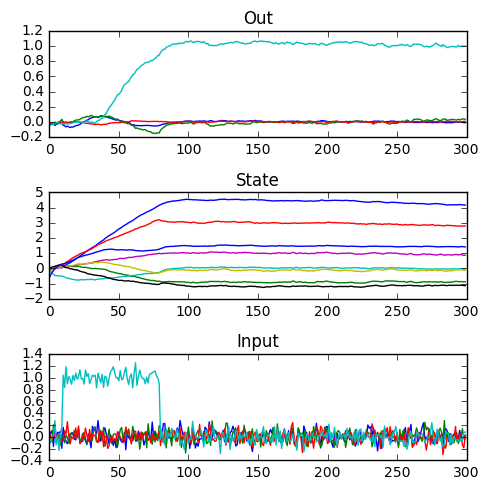

In [4]:
W = weights['W_rec']
brec = weights['b_rec']

data = generator.next()

sim = Simulator(params, weights_path=weights_path)
output,states = sim.run_trial(data[0][0,:,:],t_connectivity=False)

plt.figure(figsize=(5,5))
plt.subplot(3,1,1)
plt.plot(output[:,0,:])
plt.title('Out')
plt.subplot(3,1,2)
plt.plot(states[:,0,:])
plt.title('State')
plt.subplot(3,1,3)
plt.plot(data[0][0,:,:])
plt.title('Input')

plt.tight_layout()
plt.show()

In [5]:
s = np.zeros([data[0].shape[1],data[0].shape[0],W.shape[0]])
for ii in range(data[0].shape[0]):
    s[:,ii,:] = sim.run_trial(data[0][ii,:,:],t_connectivity=False)[1].reshape([data[0].shape[1],W.shape[0]])
    

In [6]:
response = np.argmax(relu(s[-1,:,:]).dot(weights['W_out'].T)+weights['b_out'],axis=1)

inp = np.argmax(data[0][:,40,:],axis=1)
accuracy = np.sum(inp==response)/float(len(inp))

print 'accuracy = ' + str(100*np.sum(inp==response)/float(len(inp))) + ' %'

accuracy = 100.0 %


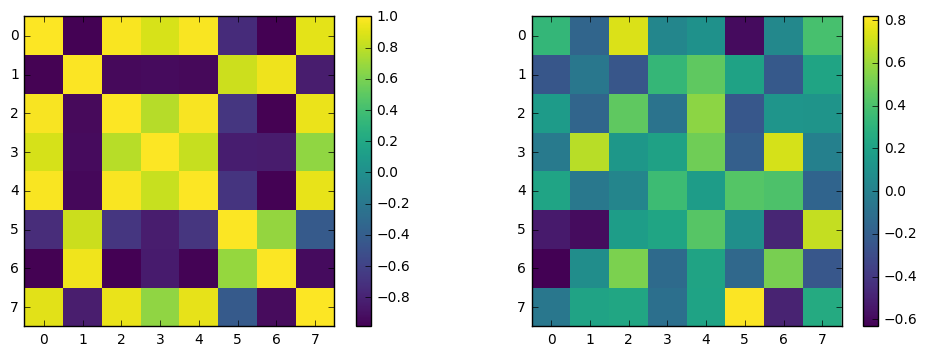

In [7]:
plt.figure(figsize=(12,4))
plt.subplot(1,2,1)
plt.imshow(np.corrcoef(states[:,0,:].T),interpolation='none')
plt.colorbar()
plt.subplot(1,2,2)
plt.imshow(W,interpolation='none')
plt.colorbar()

plt.show()

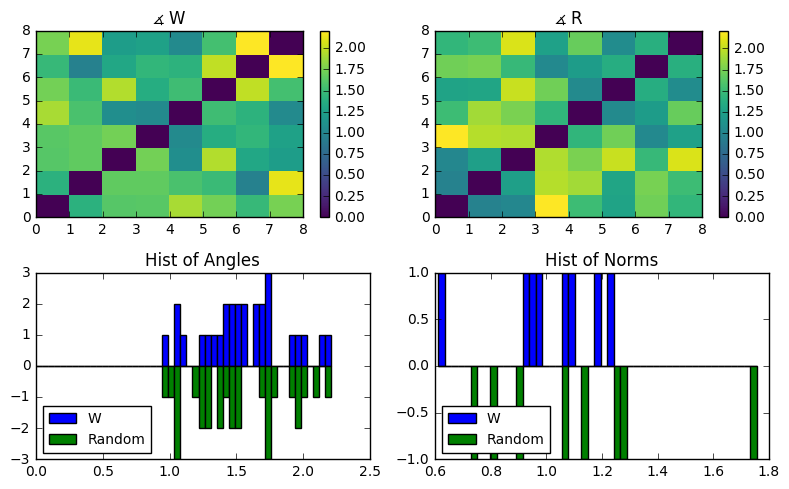

In [8]:
N = W.shape[0]

R = np.random.randn(N,N)/float(N)
R = 1.1*R/np.max(np.abs(np.linalg.eig(R)[0]))

#calculate the norm of trained rec matrix W and random gaussian matrix R

normW = calc_norm(W)
normR = calc_norm(R)

min_norm = np.min([np.min(normW),np.min(normR)])
max_norm = np.max([np.max(normW),np.max(normR)])

xx_norm = np.linspace(min_norm,max_norm,50)
histnormW, _ = np.histogram(normW,xx_norm)
histnormR, _ = np.histogram(normR,xx_norm)

#calculate hists for angles between columns

angle_W = np.arccos(np.clip((W.T.dot(W))/np.outer(normW,normW),-1.,1.))
angle_R = np.arccos(np.clip((R.T.dot(R))/np.outer(normR,normR),-1.,1.))

min_val = np.min([np.min(angle_W),np.min(angle_R)])
max_val = np.max([np.max(angle_W),np.max(angle_R)])
            
xx = np.linspace(min_val,max_val,50)
histW, bin_edgesW = np.histogram(angle_W[np.tril(np.ones_like(W),-1)>0],xx)
histR, bin_edgesR = np.histogram(angle_R[np.tril(np.ones_like(R),-1)>0],xx)

plt.figure(figsize=(8,5))
plt.subplot(2,2,1)
plt.pcolormesh(angle_W)
plt.colorbar()
plt.title('$\measuredangle$ W')

plt.subplot(2,2,2)
plt.pcolormesh(angle_R)
plt.colorbar()
plt.title('$\measuredangle$ R')

plt.subplot(2,2,3)
plt.bar(xx[:-1],histW,width=bin_edgesW[1]-bin_edgesW[0])
plt.bar(xx[:-1],-histR,width=bin_edgesR[1]-bin_edgesR[0],color='g')

plt.legend(['W','Random'],fontsize=10,loc='lower left')
plt.title('Hist of Angles')

plt.subplot(2,2,4)
plt.bar(xx_norm[:-1],histnormW,width=xx_norm[1]-xx_norm[0])
plt.bar(xx_norm[:-1],-histnormR,width=xx_norm[1]-xx_norm[0],color='g')

plt.legend(['W','Random'],fontsize=10,loc='lower left')
plt.title('Hist of Norms')


# plt.hist(R.T.dot(R)[np.tril(np.ones_like(R))>0],20,alpha=.5)

plt.tight_layout()
plt.show()

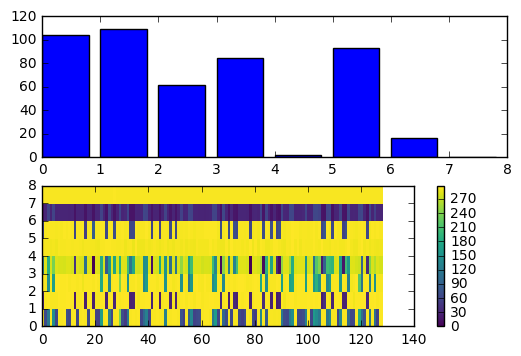

In [9]:
#Variance in number of time steps active across trials

plt.subplot(2,1,1)
plt.bar(range(8),np.std(np.sum(s>0,axis=0),axis=0))

plt.subplot(2,1,2)
plt.pcolormesh(np.sum(s>0,axis=0).T)
plt.colorbar()

# plt.hist(np.var(np.sum(s>0,axis=0),axis=0),40)
plt.show()

(128, 8)
(128,)


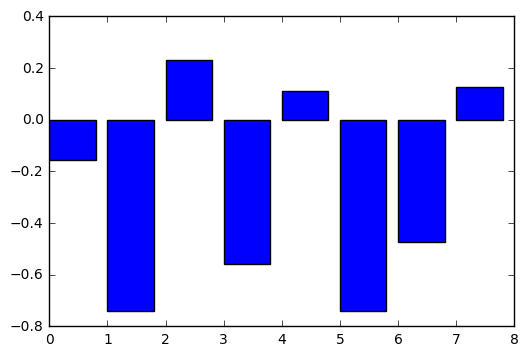

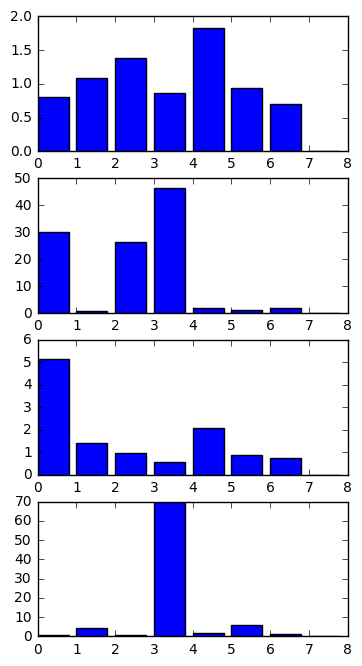

In [10]:
print np.sum(s>0,axis=0).shape
print inp.shape
plt.figure()
plt.bar(range(n_rec),np.corrcoef(np.sum(s>0,axis=0).T,inp.reshape([128,1]).T)[:-1,-1])

plt.figure(figsize=(4,8))
for ii in range(n_in):
    plt.subplot(n_in,1,ii+1)
    plt.bar(range(n_rec),np.std(np.sum(s[:,inp==ii,:]>0,axis=0),axis=0))

plt.show()

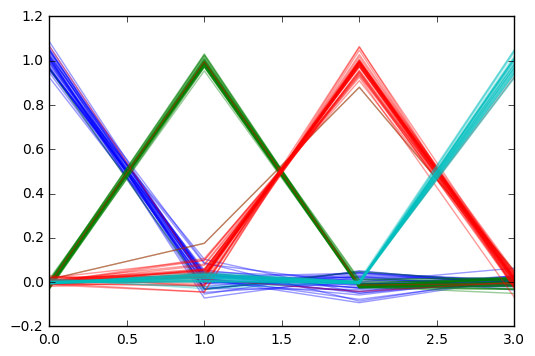

In [11]:
fig = plot_outputs_by_input(s,weights,n=4)

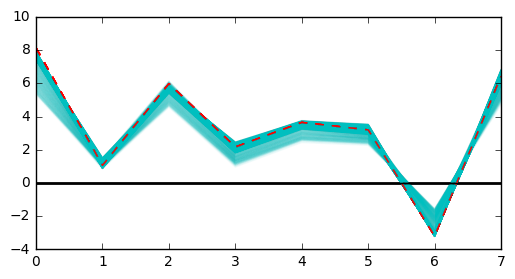

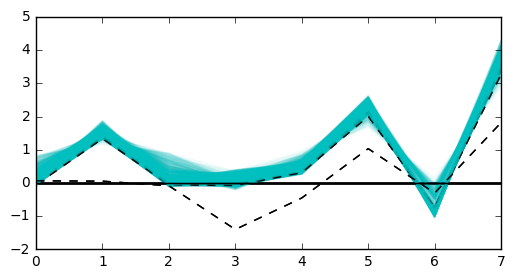

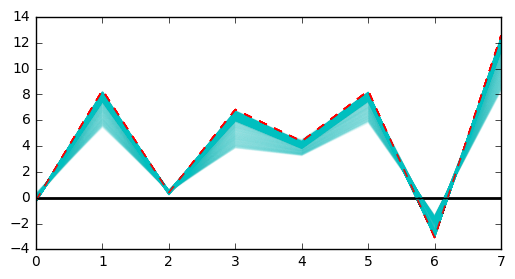

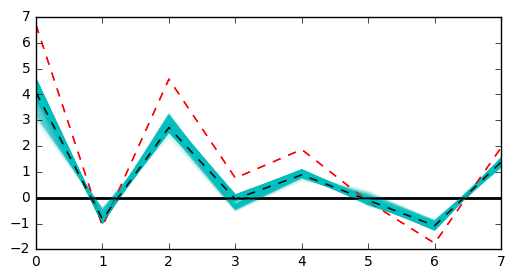

In [12]:
for ii in range(n_in):
    fig = plot_fps_vs_activity(s[:,inp==ii,:],W,brec,n=10)

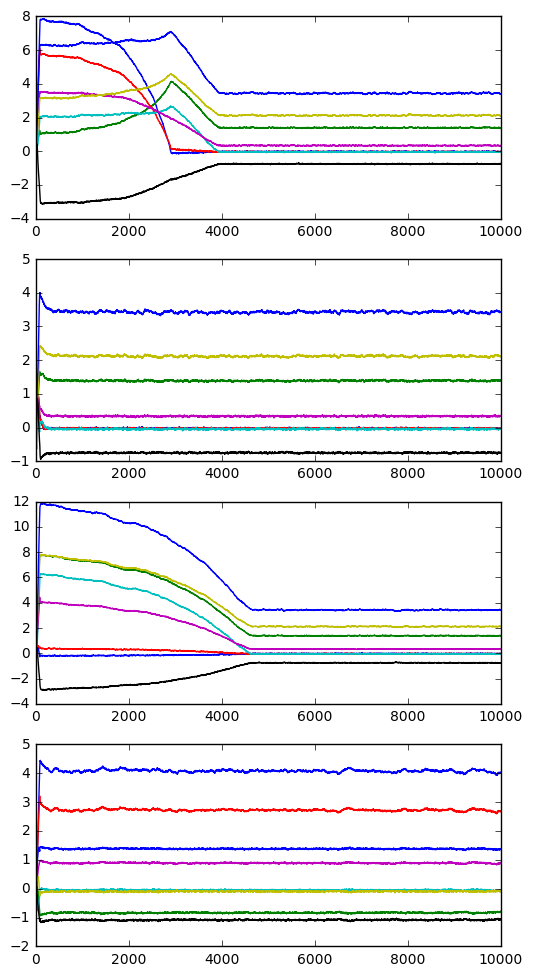

In [34]:
def long_duration_trial(n_in,sim,W,long_trial_steps=10000):
#     long_trial_steps = 10000

    long_in = np.zeros([long_trial_steps,n_in,n_in])
    for ii in range(n_in):
        long_in[10:80,ii,ii] = 1

    s_long = np.zeros([long_in.shape[0],long_in.shape[1],W.shape[0]])
    for ii in range(n_in):
        s_long[:,ii,:] = sim.run_trial(long_in[:,ii,:],t_connectivity=False)[1].reshape([long_in.shape[0],W.shape[0]])

    plt.figure(figsize=(6,12))
    for ii in range(n_in):
        plt.subplot(n_in,1,ii+1)
        plt.plot(s_long[:,ii,:])
    
    return fig
  
fig = long_duration_trial(n_in,sim,W)
plt.show()

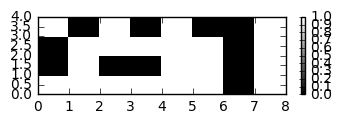

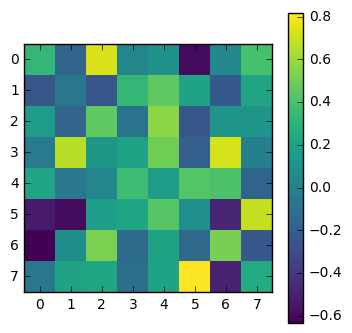

In [14]:
plt.figure(figsize=(4,1))
plt.pcolormesh(s_long[300,:,:]>0,cmap='gray')
plt.colorbar()
plt.figure(figsize=(4,4))
plt.imshow(W,interpolation='none')
plt.colorbar()
plt.show()

/Users/daniel/anaconda/lib/python2.7/site-packages/numpy/core/numeric.py:531: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


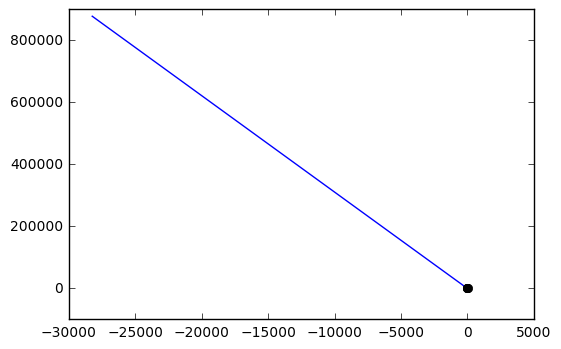

In [15]:

s_pca = demean(s_long[300,:,:])
c_pca = np.cov(s_pca.T)
evals,evecs = np.linalg.eig(c_pca)

for ii in range(n_in):
    plt.plot(s_long[:,ii,:].dot(evecs[:,0]),s_long[:,ii,:].dot(evecs[:,1]))
    plt.plot(s_long[300,ii,:].dot(evecs[:,0]),s_long[300,ii,:].dot(evecs[:,1]),'ko')
    
plt.show()

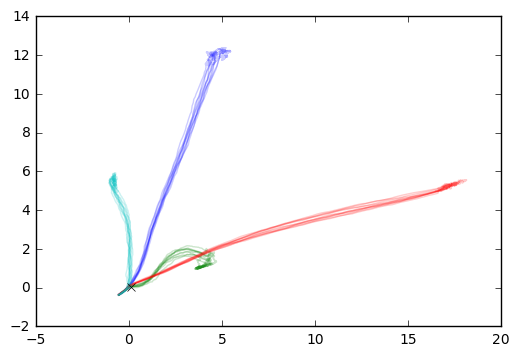

In [39]:
def pca_plot(n_in,s_long,s):

    s_pca = demean(s_long[300,:,:])
    c_pca = np.cov(s_pca.T)
    evals,evecs = np.linalg.eig(c_pca)

    fig = plt.figure()
    for ii in range(n_in):
        for jj in range(n_reps):
            plt.plot(s[:,inp==ii,:][:,jj,:].dot(evecs[:,0]),s[:,inp==ii,:][:,jj,:].dot(evecs[:,1]),c=colors[ii],alpha=.2)

    plt.plot(brec.dot(evecs[:,0]),brec.dot(evecs[:,1]),'kx')
    
    return fig

fig = pca_plot(n_in,s_long,s)

plt.show()

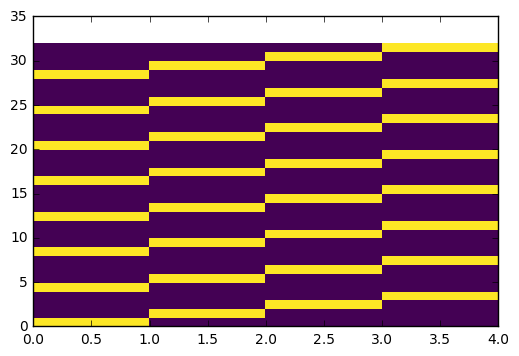

In [17]:
#single neuron ablations

abl_trial_steps = 1000
t_cons = []

abl_in = np.zeros([abl_trial_steps,n_in*n_rec,n_in])
for jj in range(n_rec):
    for ii in range(n_in):
        abl_in[10:80,ii+jj*n_in,ii] = 1
        mask = np.ones([n_rec,n_rec])
        mask[:,jj] = 0
        t_cons.append([mask])
        
plt.pcolormesh(abl_in[20,:,:])
plt.show()
    
s_abl = np.zeros([abl_in.shape[0],abl_in.shape[1],W.shape[0]])
for ii in range(n_in*n_rec):
    s_abl[:,ii,:] = sim.run_trial(abl_in[:,ii,:],t_connectivity=t_cons[ii]*abl_trial_steps)[1].reshape([abl_in.shape[0],W.shape[0]])

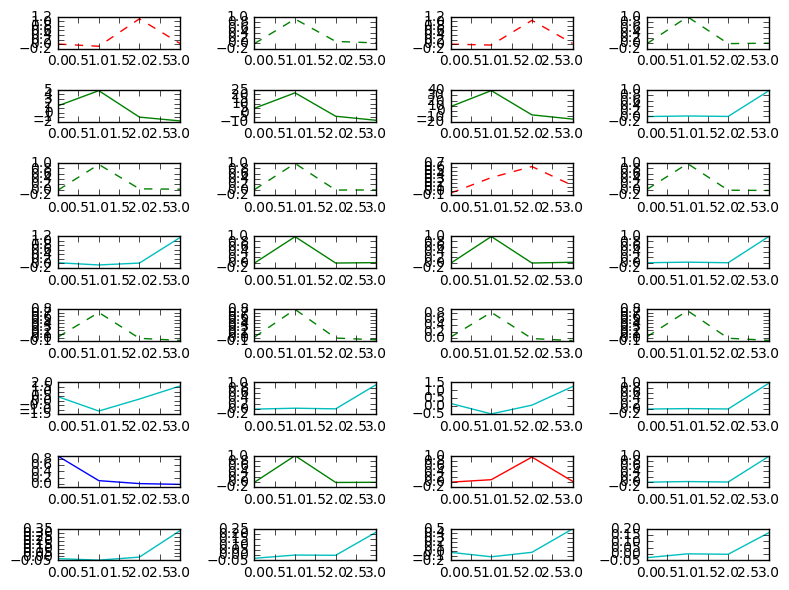

In [29]:
#Rows ablated neuron, Columns input
def ablation_analysis(n_rec,n_in,sim):

    abl_trial_steps = 1000
    t_cons = []

    abl_in = np.zeros([abl_trial_steps,n_in*n_rec,n_in])
    for jj in range(n_rec):
        for ii in range(n_in):
            abl_in[10:80,ii+jj*n_in,ii] = 1
            mask = np.ones([n_rec,n_rec])
            mask[:,jj] = 0
            t_cons.append([mask])

    # plt.pcolormesh(abl_in[20,:,:])
    # plt.show()

    s_abl = np.zeros([abl_in.shape[0],abl_in.shape[1],W.shape[0]])
    for ii in range(n_in*n_rec):
        s_abl[:,ii,:] = sim.run_trial(abl_in[:,ii,:],t_connectivity=t_cons[ii]*abl_trial_steps)[1].reshape([abl_in.shape[0],W.shape[0]])

    count = 1
    outcome = np.zeros([n_rec,n_in])
    fig = plt.figure(figsize=(8,6))
    for ii in range(n_rec):
        for jj in range(n_in):
            plt.subplot(n_rec,n_in,count)
            response = relu(s_abl[300,count-1,:]).dot(weights['W_out'].T) + weights['b_out']
            stable = np.max(np.linalg.eig(W*(s_abl[300,ii,:]>0)-np.eye(n_rec))[0].real)<0
    #         in_part = np.sum(np.linalg.inv(np.eye(n_rec)-W*(s_abl[300,ii,:]>0)).dot(brec) != s_abl[300,ii,:]>0) == 0
            outcome[ii,jj] = np.argmax(response)
            if stable:
                plt.plot(response,c=colors[np.argmax(response)])
            else:
                plt.plot(response,'--',c=colors[np.argmax(response)])

            count += 1
    
    plt.tight_layout()
    
    return fig

fig = ablation_analysis(n_rec,n_in,sim)

plt.show()

0.00792624286131
-0.114920305751
0.00273899974914
-0.0404302471303


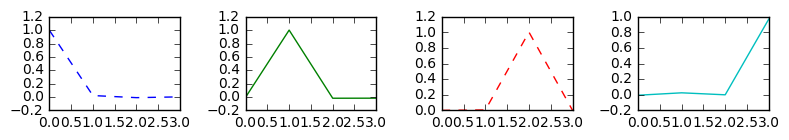

In [40]:
def plot_mean_output_by_input(n_in,s_long):

    fig = plt.figure(figsize=(8,1.5))
    for ii in range(n_in):
        plt.subplot(1,n_in,ii+1)
        response = relu(s_long[300,ii,:]).dot(weights['W_out'].T) + weights['b_out']
        max_real = np.max(np.linalg.eig(W*(s_long[300,ii,:]>0)-np.eye(n_rec))[0].real)
        stable = max_real<0
        print max_real
        if stable:
            plt.plot(response,c=colors[np.argmax(response)])
        else:
            plt.plot(response,'--',c=colors[np.argmax(response)])
          
        plt.tight_layout()
        
    return fig

fig = plot_mean_output_by_input(n_in,s_long)
        

plt.show()

0.00792624286131
-0.114920305751
0.00273899974914
-0.0404302471303


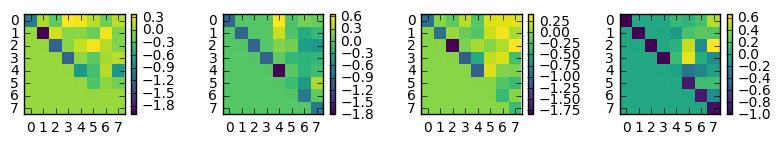

In [20]:
plt.figure(figsize=(8,1.5))
for ii in range(n_in):
    plt.subplot(1,n_in,ii+1)
    weff = W*(s_long[300,ii,:]>0)-np.eye(n_rec)
    response = relu(s_long[300,ii,:]).dot(weights['W_out'].T) + weights['b_out']
    max_real = np.max(np.linalg.eig(weff)[0].real)
    stable = max_real<0
    print max_real
    if stable:
#         print 'stable'
#         print weff.T.dot(weff) - weff.dot(weff.T)
        plt.imshow(schur(weff,'complex')[0].real,interpolation='none')
    else:
#         print 'unstable'
#         print weff.T.dot(weff) - weff.dot(weff.T)
        plt.imshow(schur(weff,'complex')[0].real,interpolation='none')
    plt.colorbar()
        
plt.tight_layout()
plt.show()

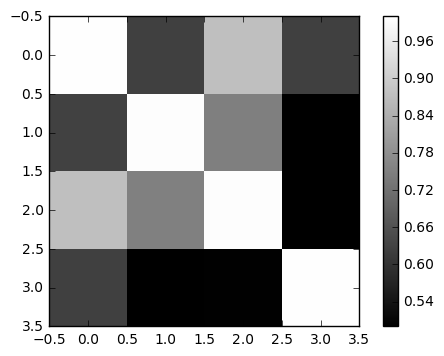

In [21]:
out_parts = 2*(s_long[300,:,:]>0).astype('float')-1
# print out_parts
pct_overlap = (out_parts.dot(out_parts.T)+n_rec)/(n_rec*2.)

plt.imshow(pct_overlap,interpolation='none',cmap='gray')
plt.colorbar()
plt.show()

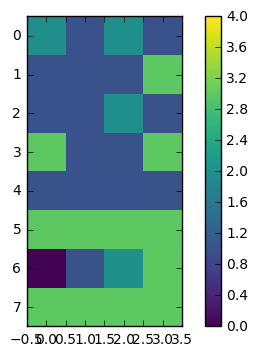

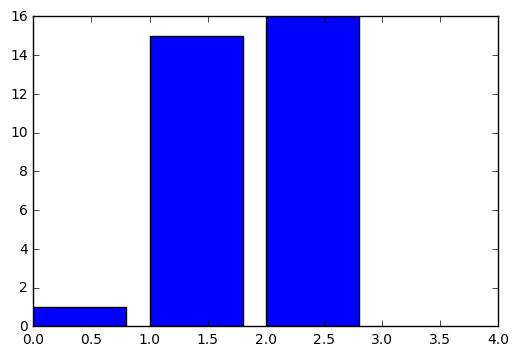

In [22]:
plt.figure()
plt.imshow(outcome,interpolation='none',vmin=0,vmax=n_in)
plt.colorbar()

plt.figure()
vals,bin_edges = np.histogram(outcome.flatten(),range(n_in))
plt.bar(bin_edges[:-1],vals)
plt.xlim([0,n_in])
plt.show()

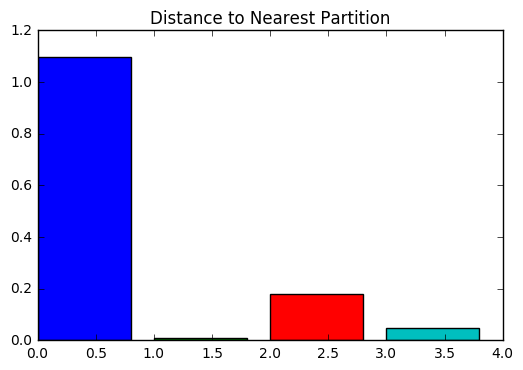

In [23]:
part_dist = np.min(np.abs(s_long[300,:,:]),axis=1)
plt.bar(np.arange(4),part_dist,color=['b','g','r','c'])
plt.title('Distance to Nearest Partition')
plt.show()

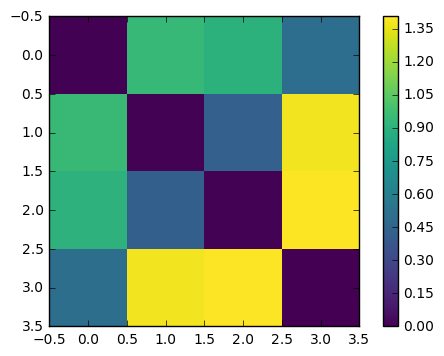

In [24]:
fps = s_long[300,:,:].T
angle_fps = np.arccos(np.clip((fps.T.dot(fps))/np.outer(calc_norm(fps),calc_norm(fps)),-1.,1.))
plt.imshow(angle_fps,interpolation='none')
plt.colorbar()
plt.show()

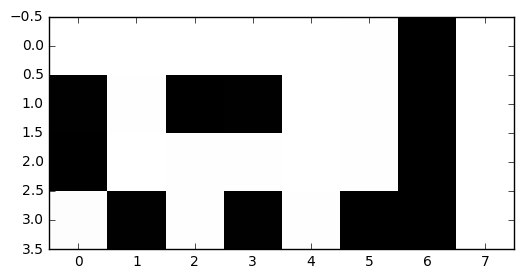

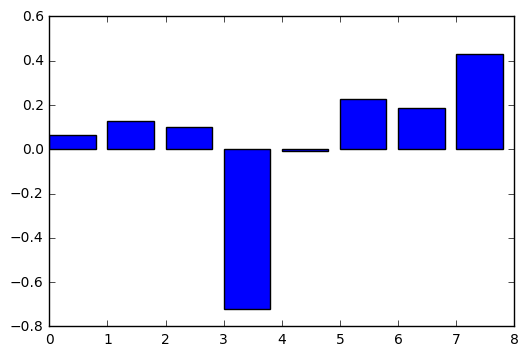

In [25]:
plt.imshow(s_long[300,:,:]>0,cmap='gray',interpolation='none')
plt.figure()
plt.bar(range(8),brec)
plt.show()

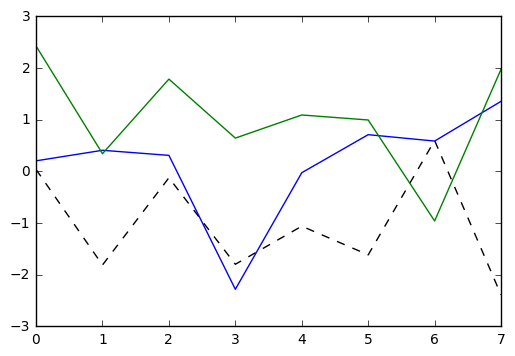

[-0.05405858+0.j]
[ 0.06509562+0.j          0.18647505+0.j         -0.05692447+0.j
 -0.11167368-0.18240895j -0.11167368+0.18240895j -0.05405858+0.j
 -0.39415233-0.2350894j  -0.39415233+0.2350894j ]


In [27]:
def norm(x):
    return x/np.std(x)

weff = W*(s_long[300,2,:]>0)-np.eye(n_rec)
pos_mode = np.where(np.linalg.eig(weff)[0].real>0)[0]

unstable_evecs = np.linalg.eig(weff)[1][:,pos_mode]
fp = s_long[300,0,:]

plt.plot(norm(unstable_evecs),'--k')
plt.plot(norm(brec),'b')
plt.plot(norm(fp),'g')
plt.show()

print brec.dot(unstable_evecs)
print brec.dot(np.linalg.eig(weff)[1])

In [37]:
data[0].shape[2]

4